## Greedy feature selection

In [48]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

In [6]:
df = pd.read_csv('document/penguins_size.csv')
df.loc[df[df['sex'] == '.'].index, 'sex'] = np.nan

In [7]:
# threshを指定することでその数以上の特徴量データを持っていないとドロップする
df.dropna(thresh=3, inplace=True)

In [53]:
X = df.drop('species', axis=1)
y = df['species']

# 欠損値を新しいカテゴリ'NaN'に代入
imputer = SimpleImputer(strategy='constant', fill_value='NaN')
imputer.set_output(transform='pandas')
X['sex'] = imputer.fit_transform(X[['sex']])


# pipelineのためのダミー変数クラス
class GetDummies(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.X_columns = None
    
    def fit(self, X, y):
        self.X_columns = pd.get_dummies(X).columns.to_list()
        return self
    
    def transform(self, X):
        X_dummies = pd.get_dummies(X)
        return X_dummies.reindex(columns=self.X_columns, fill_value=0)
    
    
# 特徴量エンジニアリング
# 多項式特徴量
poly = PolynomialFeatures(degree=2, include_bias=False)
X[['culmen_length_mm', 'culmen_depth_mm', 'culmen_length_mm^2', 'culmen_length_mm * culmen_length_mm', 'culmen_depth_mm^2',]] = poly.fit_transform(X[['culmen_length_mm', 'culmen_depth_mm']])

# 四則演算
X['culmen_diff'] = X['culmen_length_mm'] - X['culmen_depth_mm']
X['culmen_ratio'] = X['culmen_length_mm'] / X['culmen_depth_mm']


# Pipeline
pipeline =Pipeline(steps=[('dummy', GetDummies()),
                          ('scaler', StandardScaler()),
                          ('model', LogisticRegression())])


# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)




In [213]:
# Greedy feature selection
# gfs = GreedyFeatureSElection(Piplene=pipline, cv=cv)
# gfs.select_feature(X, y)
# gfs.scores -> 各最高精度が見れる
# gfs.selected_features -> 選択された特徴量が見れる


class GreedyFeatureSelection:
    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.scores = []
        self.selected_features = []
        
    
    def select_feature(self, X, y):
        
        while True:
            # Xのカラム名リスト
            X_cols = X.columns.to_list()
            
            # 最初にiterとそれ以降のiterで分岐
            if len(self.scores) == 0:
                selected_cols = X_cols
            else:
                # self.selected_featuresに入っていないカラムを抽出
                selected_cols = [col for col in X_cols if col not in self.selected_features]

            # 各カラムを使用した精度を格納
            scores = {}
            for col in selected_cols:
                # 格納したカラム名との結合 -> list型
                cols = [col] + self.selected_features
                selected_col_X = X[cols]
                score = cross_val_score(self.pipeline, selected_col_X, y, cv=self.cv, scoring='accuracy')
                scores[col] = score.mean()

            # 一番高い精度のcolを選出
            best_col = max(scores,  key=scores.get)
            best_score = scores[best_col]
            self.selected_features.append(best_col)
            self.scores.append(best_score)
            
            # bestscoreが向上していなかったらbreak
            # 初回のiterは回避
            if len(self.scores) > 1:
                if best_score <= self.scores[-2]:
                    self.selected_features.pop(-1)
                    self.scores.pop(-1)
                    break

            

    

In [214]:
gfs = GreedyFeatureSelection(pipeline=pipeline, cv=cv)
gfs.select_feature(X, y)

In [215]:
gfs.selected_features

['culmen_ratio', 'island', 'culmen_diff', 'body_mass_g']

In [216]:
gfs.scores

[0.9619883040935672, 0.9912280701754387, 0.9970760233918128, 1.0]

## かめさんのコード => 自分で作成したものと比較用に

In [ ]:
class GreedyFeatureSelection():
    
    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.selected_features = []
        self.scores = [0]
    
    def select_feature(self, X, y):
        
        all_features = X.columns
        
        while True:
            # print('greedy selection started')
            best_score = self.scores[-1]
            candidate_feature = None
            for feature in all_features:
                if feature in self.selected_features:
                    continue
                # print(f'{feature} started')
                features = self.selected_features + [feature]
                X_train = X[features]
                # 評価
                score = cross_val_score(self.pipeline, X_train, y, cv=self.cv).mean()
                # print(f'{features} score: {score}')
                if score > best_score:
                    # print(f'best score updated {best_score} -> {score}')
                    best_score = score
                    candidate_feature = feature
            
            if candidate_feature is not None:
                # print(f'========{candidate_feature} is selected=============')
                self.scores.append(best_score)
                self.selected_features.append(candidate_feature)
            else:
                break

## RFE

In [243]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [228]:
rfe = RFE(DecisionTreeClassifier(), n_features_to_select=6)
X = pd.get_dummies(X, drop_first=True)
rfe.fit(X, y)
rfe.set_output(transform='pandas')
rfe.transform(X)

,culmen_diff,culmen_ratio,island_Dream,island_Torgersen,sex_MALE,sex_NaN
0,20.4,2.090909,0,1,1,0
1,22.1,2.270115,0,1,0,0
2,22.3,2.238889,0,1,0,0
4,17.4,1.901554,0,1,0,0
5,18.7,1.907767,0,1,1,0
...,...,...,...,...,...,...
338,33.5,3.445255,0,0,0,0
340,32.5,3.272727,0,0,0,0
341,34.7,3.210191,0,0,1,0
342,30.4,3.054054,0,0,0,0


In [229]:
# 今回6つの特徴量が選択される => 1で表される
rfe.ranking_

array([8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1])

In [230]:
rfe.feature_names_in_

array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'culmen_length_mm^2',
       'culmen_length_mm * culmen_length_mm', 'culmen_depth_mm^2',
       'culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [232]:
# こんな風に取り出しても良いけど
rfe.feature_names_in_[rfe.ranking_==1]

array(['culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [233]:
# .support_を使用すると簡単
rfe.support_

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True])

In [234]:
rfe.feature_names_in_[rfe.support_]

array(['culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [237]:
# インスタンス化したrfeをpipelineで使用する
pipeline = Pipeline([('rfe', rfe), ('scaler', StandardScaler()), ('model', LogisticRegression())])
cross_val_score(pipeline, X, y, cv=cv)

array([1.        , 1.        , 0.99122807])

In [263]:
# RFECV
# RFECVは自動で特徴量を決めてくれる
rfecv = RFECV(DecisionTreeClassifier(), cv=cv)
rfecv.fit(X, y)
rfecv.transform(X)

array([[20.4       ,  2.09090909,  0.        ],
       [22.1       ,  2.27011494,  0.        ],
       [22.3       ,  2.23888889,  0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ],
       [30.4       ,  3.05405405,  0.        ],
       [33.8       ,  3.09937888,  0.        ]])

In [264]:
# どの特徴量が選ばれたのか？
rfecv.feature_names_in_[rfecv.support_]

array(['culmen_diff', 'culmen_ratio', 'island_Dream'], dtype=object)

In [265]:
rfecv.cv_results_

{'mean_test_score': array([0.8625731 , 0.97953216, 0.98830409, 0.98830409, 0.98830409,
        0.98830409, 0.98830409, 0.98538012, 0.98538012, 0.97660819,
        0.98830409, 0.98830409, 0.98538012]),
 'std_test_score': array([0.1063138 , 0.01094052, 0.00413513, 0.00413513, 0.00413513,
        0.00413513, 0.00413513, 0.00413513, 0.00413513, 0.00827025,
        0.00413513, 0.00413513, 0.00413513]),
 'split0_test_score': array([0.97368421, 0.99122807, 0.99122807, 0.99122807, 0.99122807,
        0.99122807, 0.99122807, 0.98245614, 0.98245614, 0.98245614,
        0.99122807, 0.99122807, 0.99122807]),
 'split1_test_score': array([0.89473684, 0.98245614, 0.99122807, 0.99122807, 0.99122807,
        0.99122807, 0.99122807, 0.99122807, 0.99122807, 0.96491228,
        0.99122807, 0.99122807, 0.98245614]),
 'split2_test_score': array([0.71929825, 0.96491228, 0.98245614, 0.98245614, 0.98245614,
        0.98245614, 0.98245614, 0.98245614, 0.98245614, 0.98245614,
        0.98245614, 0.98245614, 0.98

<ErrorbarContainer object of 3 artists>

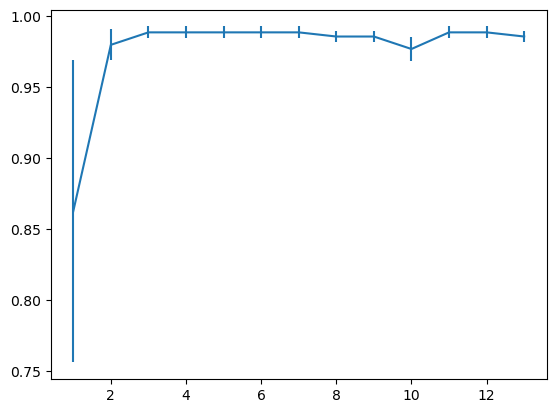

In [266]:
plt.errorbar(range(1, 1+len(rfecv.cv_results_['mean_test_score'])), 
            rfecv.cv_results_['mean_test_score'],
            yerr=rfecv.cv_results_['std_test_score'],)

・'mean_test_score'において、3つ目以8まで降同じ値が続いているので3つ目の特徴まで選択された  
・自動で特徴量数を選択してくれるRFECVの方が使いやすいかも

## モデルの係数や重要度で特徴量選択

・予算等の関係から全ての特徴量を使えない時に使用することが多い（多少の精度を犠牲にすることもある。）

In [249]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


In [258]:
sfm = SelectFromModel(RandomForestClassifier(random_state=0, ))
sfm.fit(X, y)
sfm.set_output(transform='pandas')
X_selected = sfm.transform(X)
X_selected

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,culmen_length_mm^2,culmen_depth_mm^2,culmen_diff,culmen_ratio
0,39.1,18.7,181.0,1528.81,349.69,20.4,2.090909
1,39.5,17.4,186.0,1560.25,302.76,22.1,2.270115
2,40.3,18.0,195.0,1624.09,324.00,22.3,2.238889
4,36.7,19.3,193.0,1346.89,372.49,17.4,1.901554
5,39.3,20.6,190.0,1544.49,424.36,18.7,1.907767
...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,2227.84,187.69,33.5,3.445255
340,46.8,14.3,215.0,2190.24,204.49,32.5,3.272727
341,50.4,15.7,222.0,2540.16,246.49,34.7,3.210191
342,45.2,14.8,212.0,2043.04,219.04,30.4,3.054054


In [254]:
# 重要度の結果
sfm.estimator_.feature_importances_

array([0.08924232, 0.07961904, 0.09933245, 0.0525517 , 0.08072858,
       0.01467092, 0.10925035, 0.14543881, 0.24562145, 0.07424349,
       0.00630753, 0.00299336, 0.        ])

In [256]:
sfm.feature_names_in_[sfm.get_support()]

array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'culmen_length_mm^2', 'culmen_depth_mm^2', 'culmen_diff',
       'culmen_ratio'], dtype=object)

## L1正則化項で特徴量選択

In [283]:
# sfmにL1ノルムが設定できるモデルを組み込む
# 自分で作成することもできるが、この方法を使う方が、簡単に作成できてpiplineも使える
sfm = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))

In [281]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                    ('feature selection', sfm)])

pipeline.set_output(transform='pandas')
pipeline.fit_transform(X, y)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,culmen_length_mm * culmen_length_mm,culmen_depth_mm^2,culmen_diff,culmen_ratio,island_Dream,island_Torgersen,sex_MALE
0,-0.884499,0.785449,-1.418347,-0.564142,-0.170197,0.768371,-1.024588,-1.036429,-0.754193,2.388699,1.017700
1,-0.811126,0.126188,-1.062250,-0.501703,-0.550838,0.070068,-0.751183,-0.675598,-0.754193,2.388699,-0.982607
2,-0.664380,0.430462,-0.421277,-1.188532,-0.220261,0.386112,-0.719018,-0.738471,-0.754193,2.388699,-0.982607
4,-1.324737,1.089724,-0.563715,-0.938776,-0.368543,1.107627,-1.507068,-1.417695,-0.754193,2.388699,-0.982607
5,-0.847812,1.748985,-0.777373,-0.689020,0.510134,1.879435,-1.297994,-1.405186,-0.754193,2.388699,1.017700
...,...,...,...,...,...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175,-0.903628,-1.642135,1.082241,1.690550,-0.754193,-0.418638,-0.982607
340,0.527932,-1.445897,1.003109,0.809516,-0.707537,-1.392157,0.921415,1.343164,-0.754193,-0.418638,-0.982607
341,1.188289,-0.735923,1.501644,1.933419,0.351353,-0.767211,1.275233,1.217248,-0.754193,-0.418638,1.017700
342,0.234440,-1.192335,0.789451,1.246590,-0.709967,-1.175658,0.583679,0.902865,-0.754193,-0.418638,-0.982607


In [282]:
sfm.estimator_.coef_

array([[ 0.        ,  0.        , -0.16471467,  0.        ,  0.        ,
         0.        ,  0.01637399, -6.83155071, -0.19960674, -0.34668202,
         0.8920866 ,  1.17494055,  0.        ],
       [ 4.21271482,  0.        ,  0.        , -2.37015805,  0.        ,
         0.14776045,  0.        ,  0.        ,  0.        ,  2.66080323,
         0.        , -0.75570219,  0.        ],
       [ 0.        , -2.7677246 ,  1.68201918,  1.82121475,  0.        ,
         0.        ,  0.        ,  0.        ,  0.52376917, -0.24724443,
         0.        ,  0.        ,  0.        ]])

# このセクションのまとめ

・特徴エンジニアリングの後に特徴量の選択を行う  
・特徴量が多いとvarianceが高くなったり、計算量が多くなったりする -> 重要な特徴量だけのこす  
・greedy feature selection -> 精度が上がるか  
・recursive feature elimination -> 重要度の低いものを減らしていく  
・モデルの特徴量の係数や重要度をみて、閾値より高い特徴量を残す  
　-> 線形回帰：t検定量  
　-> 決定木:重要度  
・L1正則化項  
　-> 自動で特徴量を選択できる